# Iterative transfer learning

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp
from tqdm.auto import tqdm

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.utils_plot import plot_loss_and_all_solution
from src.load_save import load_run_history
from src.transfer_learning import compute_H_and_dH_dt, analytically_compute_weights

from src.utils_plot import plot_transfer_learned_and_analytical

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [4]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Sun Mar  3 14:19:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0              N/A / ERR! |      0MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

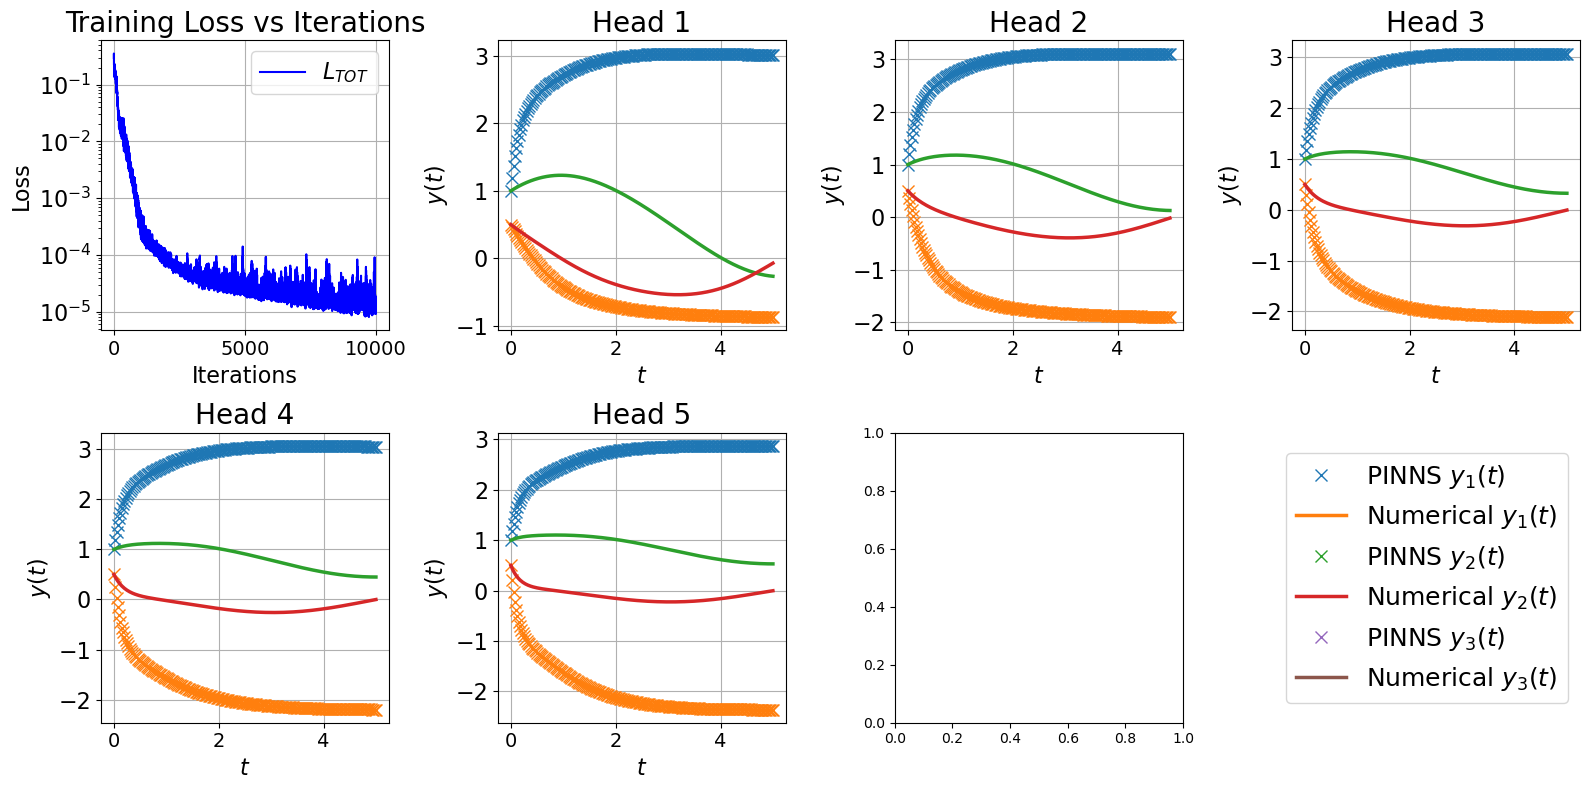

In [8]:
file_name = "nonlinear_repara_2141608"
equation_name = "duffing"

trained_model, \
x_range, \
iterations, \
hid_lay, \
num_equations, \
num_heads, \
loss_hist, \
alpha_list, \
A_list, \
IC_list, \
force_list = load_run_history(equation_name, file_name, dev, prev=False)

reparametrization=True
beta=0.5
def equation(t, y, alpha, beta=beta):
    if isinstance(y, torch.Tensor):
      yp = torch.zeros_like(y)
      force = torch.cos(t)
    elif isinstance(y, np.ndarray):
      yp = np.zeros_like(y)
      force = np.cos(t)
    yp[..., 0] = y[..., 1]
    yp[..., 1] = -0.1*y[..., 0] - alpha*y[..., 1] - beta*y[..., 0]**3 + force
    return yp
equation_list = [lambda t, y, Alpha=alpha: equation(t, y, Alpha) for alpha in alpha_list]

numerical_sol_fct = lambda x, v, alpha, beta: (solve_ivp(equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(alpha, beta), t_eval=x.squeeze(), method="Radau").y.T)
numerical_sol_list = [lambda x, IC=ic.detach().cpu().numpy(), Alpha=alpha, beta=beta: numerical_sol_fct(x, IC, Alpha, beta) for ic, alpha in zip(IC_list, alpha_list)]

plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_list,
                           trained_model=trained_model, IC_list=IC_list,
                           A_list=None, force=None, train_losses=loss_hist,
                           device=dev, equation_list=equation_list,
                           reparametrization=reparametrization)

# Iterative transfer learning

In [6]:
from collections import defaultdict
import time
from tqdm.auto import trange
import torch.nn as nn

from src.loss import calc_loss_nonlinear


def transfer_learning(iterations, x_range, N, equation_transfer, IC, num_equations,
                      dev, hid_lay, pretrained_model, lr, optimizer_name,
                      decay=True, gamma=0.1, reparametrization=False, tqdm_bool=False):

    for i, pretrained_layer in enumerate(pretrained_model.hidden_layers):
        if isinstance(pretrained_layer, nn.Linear):
            for param in pretrained_layer.parameters():
                param.requires_grad = False  # Freeze the layer
    pretrained_model.multi_head_output = nn.ModuleList([nn.Linear(hid_lay[-1], num_equations)]).double()
    pretrained_model.multi_head_output[0].bias = None
    pretrained_model.n_heads = 1
    pretrained_model.to(dev)
    
    # set-up the optimizer
    if optimizer_name=="LBFGS":
        optimizer = torch.optim.LBFGS(pretrained_model.parameters(), history_size=100, max_iter=20, lr=lr)
    if optimizer_name=="Adam":
        optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=lr)

    # store loss and mse values
    loss_history = defaultdict(list)
    start_time = time.time()

    # training loop
    for i in trange(iterations) if tqdm_bool else range(iterations):

        rng = np.random.default_rng()
        x = torch.arange(x_range[0], x_range[1], 0.001, requires_grad=True, device=dev).double()
        x = x[rng.choice(range(0, len(x)), size=N, replace=False)]
        x = x.reshape(-1, 1)
        x, _ = x.sort(dim=0)
        
        global curr_loss
        if optimizer_name=="LBFGS":
            def closure():
                optimizer.zero_grad()
                global curr_loss
                L, curr_loss = calc_loss_nonlinear(x, [equation_transfer], [IC], pretrained_model, numerical_solution=None, t_eval=None, device=dev, reparametrization=reparametrization)
                if (i % 1 == 0):
                    info_loss = f"Iterations {i}"
                    for k, v in curr_loss.items():
                        if k != "head":
                            info_loss += f", {k} = {v}"
                print(info_loss)
                L.backward(retain_graph=True)
                return L
            optimizer.step(closure)

        if optimizer_name == "Adam":
            _, curr_loss = calc_loss_nonlinear(x, [equation_transfer], [IC], pretrained_model, numerical_solution=None, t_eval=None, device=dev, reparametrization=reparametrization)
            if (i % 100 == 0):
                info_loss = f"Iterations {i}"
                for k, v in curr_loss.items():
                    if k != "head":
                        info_loss += f", {k} = {v}"
                print(info_loss)
            curr_loss['L_total'].backward()
            if decay:
                gamma = 0.95  # Adjust the decay factor accordingly
                every = 50  # Adjust the decay interval accordingly
                for param in pretrained_model.multi_head_output[0].parameters():
                    param.grad *= (gamma**((i + 1) / every))
            optimizer.step()
            optimizer.zero_grad()

        # store individual loss terms for plotting
        loss_history['L_IC'].append(curr_loss['L_IC'].detach().item())
        loss_history['L_ODE'].append(curr_loss['L_ODE'].detach().item())
        loss_history['L_total'].append(curr_loss['L_total'].detach().item())

    end_time = time.time()
    total_time = end_time - start_time
    return loss_history, pretrained_model, total_time

In [25]:
alpha_transfer = 5
#lr = 0.0001
lr=1

#iterations=1000
iterations=5

In [26]:
N=500
equation_transfer = lambda t, y, Alpha=alpha_transfer: equation(t, y, Alpha)
IC = IC_list[0]
loss_transfer, model_transfer, time_transfer = transfer_learning(iterations=iterations, x_range=x_range, N=N,
                                                                 equation_transfer=equation_transfer, IC=IC,
                                                                 num_equations=num_equations, dev=dev, hid_lay=hid_lay,
                                                                 pretrained_model=trained_model, lr=lr, optimizer_name="LBFGS",
                                                                 decay=False, gamma=0.1, reparametrization=reparametrization, tqdm_bool=True)

  0%|          | 0/5 [00:00<?, ?it/s]

Iterations 0, L_total = 0.9490669827530621, L_ODE = 0.9490669827530621, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 0.31829326304366024, L_ODE = 0.31829326304366024, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 0.16661516975546367, L_ODE = 0.16661516975546367, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 0.1617142333471834, L_ODE = 0.1617142333471834, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 0.034985597448854856, L_ODE = 0.034985597448854856, L_IC = 0.0
Iterations 0, L_total = 0.4349716402496716, L_ODE = 0.4349716402496716, L_IC = 0.0
Iterations 0, L_total = 0.029413745015499957, L_ODE = 0.029413745015499957, L_IC = 0.0
Iterations 0, L_total = 0.02846624332566844, L_ODE = 0.02846624332566844, L_IC = 0.0
Iterations 0, L_total = 0.02563431807089505, L_ODE = 0.02563431807089505, L_IC = 0.0
Iterations 0, L_total = 0.02079686482802613, L_ODE = 0.02079686482802613, L_IC = 0.0
Iterations 0, L_total = 0.015616670502849924, L_ODE = 0.015616670502849924, L_IC

In [27]:
def plot_transfer_learned_and_analytical(H, W_out, t_eval, v, A, force, num_equations, true_funct, transfer_loss, reparametrization=False):

    fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(18, 5))


    axs[0].plot(range(len(transfer_loss["L_total"])), transfer_loss["L_total"], label="$L_{TOT}$", color="b")
    axs[0].set_yscale("log")
    axs[0].set_title("Training Loss vs Iterations", fontsize=20)
    axs[0].set_xlabel('Iterations', fontsize=16)
    axs[0].set_ylabel('Loss', fontsize=16)
    axs[0].tick_params(axis='x', labelsize=14)
    axs[0].tick_params(axis='y', labelsize=16)
    axs[0].grid()
    axs[0].legend(loc='best', fontsize=16)

    # compute the transfer learned solution

    if H is not None:
        u_transfer = torch.matmul(H.double(), W_out.double())
    else:
        u_transfer = W_out(t_eval, reparametrization=reparametrization)[0].mT

    # plot the transfer learned solutions
    for i in range(num_equations):
        axs[1].plot(t_eval.detach().cpu().numpy()[::1],
                    u_transfer[:, i, :].detach().cpu().numpy() if len(u_transfer.shape) == 3 else u_transfer[:, i].detach().cpu().numpy(),
                    'x', markersize=8, label=f'Transfer Learned $y_{{{i+1}}}$', linewidth=3.5)

    # plot the true solutions
    for i in range(num_equations):
        axs[1].plot(t_eval.detach().cpu().numpy(),
                    true_funct(t_eval.detach().cpu().numpy(), v.detach().cpu(),
                               A.detach().cpu(), force.detach().cpu() if not callable(force) else force)[i]
                    if A is not None else true_funct(t_eval.detach().cpu().numpy())[..., i],
                    label=f'True $y_{{{i+1}}}$', linewidth=2.5)

    axs[1].set_title("$y(t)$ for PINNs Transfer \n and Numerical Solutions", fontsize=20)
    axs[1].set_xlabel("t", fontsize=16)
    axs[1].set_ylabel("$y(t)$", fontsize=16)
    axs[1].tick_params(axis='x', labelsize=16)
    axs[1].tick_params(axis='y', labelsize=16)
    axs[1].grid()
    axs[1].legend()

    # plot the transfer learned solutions
    for i in range(num_equations):
        x_vals = t_eval.detach().cpu().numpy()
        predicted_vals = u_transfer[:, i, :].detach().cpu().numpy().squeeze() if len(u_transfer.shape) == 3 else u_transfer[:, i].detach().cpu().numpy().squeeze(),
        true_vals = true_funct(x_vals, v.detach().cpu(), A.cpu(), force.detach().cpu() if not callable(force) else force)[i] if A is not None else true_funct(x_vals)[..., i]

        error = np.abs((predicted_vals - true_vals))
        print(f"mean {error.mean()}")
        print(f"max {error.max()}")
        axs[2].plot(t_eval.detach().cpu().numpy().squeeze(), error.squeeze(), label=f'Error $y_{{{i+1}}}$')

    axs[2].set_title("Absolute Error", fontsize=20)
    axs[2].set_xlabel("$t$", fontsize=16)
    axs[2].set_yscale('log')
    axs[2].set_ylabel('Error Value', fontsize=16)
    axs[2].tick_params(axis='x', labelsize=16)
    axs[2].tick_params(axis='y', labelsize=16)
    axs[2].grid()
    axs[2].legend()

mean 0.0003124116344072319
max 0.0007788768044012517
mean 0.0002552497266277425
max 0.00076928295755814


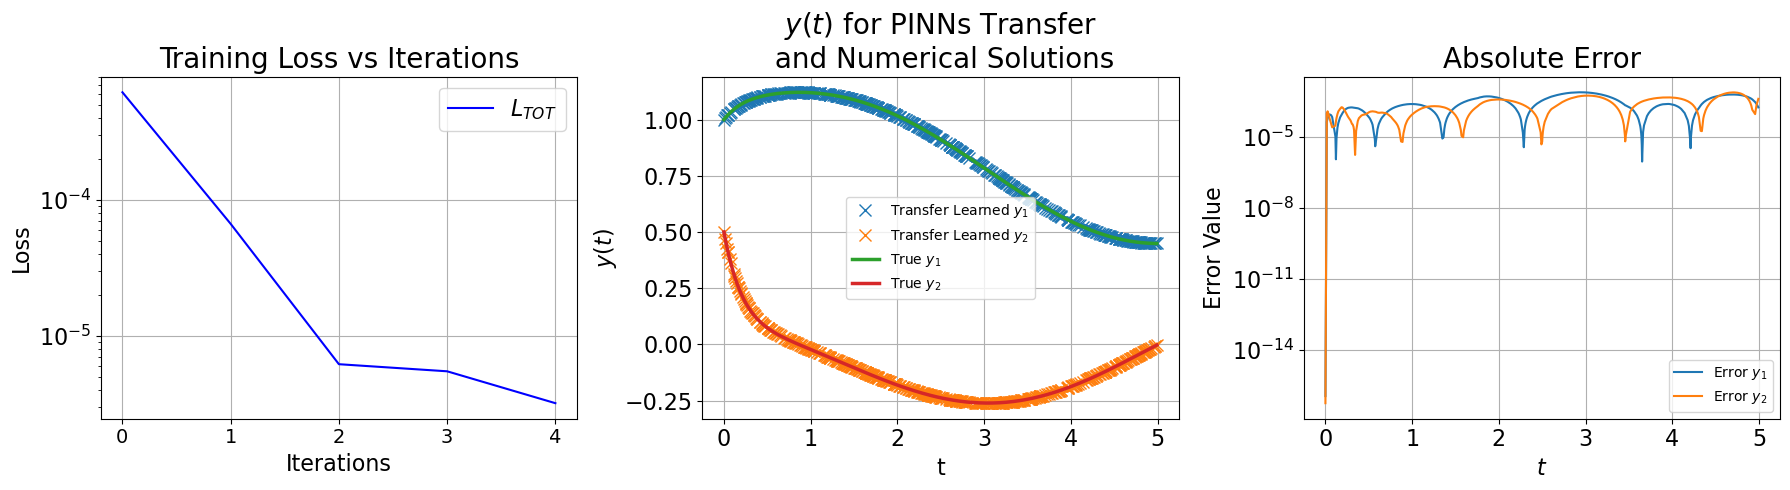

In [28]:
#from src.utils_plot import plot_transfer_learned_and_analytical

rng = np.random.default_rng()
t_eval = torch.arange(x_range[0], x_range[1], 0.001, requires_grad=True, device=dev).double()
t_eval = t_eval[np.concatenate(([0], rng.choice(range(1, len(t_eval)), size=512 - 1, replace=False)))]
t_eval = t_eval.reshape(-1, 1)
t_eval, _ = t_eval.sort(dim=0)

true_funct = lambda x: numerical_sol_fct(x, v=IC.detach().cpu().numpy(), alpha=alpha_transfer, beta=beta)
plot_transfer_learned_and_analytical(H=None, W_out=model_transfer, t_eval=t_eval, v=IC, A=None, force=None,
                                     num_equations=num_equations, true_funct=true_funct,
                                     transfer_loss=loss_transfer, reparametrization=reparametrization)

# trained multiple stiffness

In [16]:
from tqdm.auto import trange

num_heads = 1
alpha_list = [5, 10, 15, 20, 25, 30, 35, 40]

lr_list = [1, 1, 1, 0.5, 0.2, 0.1, 0.1, 0.05]
iterations_list = [10, 15, 20, 20, 20, 20, 20, 30]
solution_PINNS = []

rng = np.random.default_rng()
t_eval = torch.arange(x_range[0], x_range[1], 0.001, requires_grad=True, device=dev).double()
t_eval = t_eval[np.concatenate(([0], rng.choice(range(1, len(t_eval)), size=512 - 1, replace=False)))]
t_eval = t_eval.reshape(-1, 1)
t_eval, _ = t_eval.sort(dim=0)

for i in trange(len(alpha_list)):
    equation_transfer = lambda t, y, Alpha=alpha_list[i]: equation(t, y, Alpha)
    _, model_transfer, _ = transfer_learning(iterations=iterations_list[i], x_range=x_range, N=500,
                                             equation_transfer=equation_transfer, IC=IC_list[0],
                                             num_equations=num_equations, dev=dev, hid_lay=hid_lay,
                                             pretrained_model=trained_model, lr=lr_list[i], optimizer_name="LBFGS",
                                             decay=False, gamma=0.1, reparametrization=reparametrization, tqdm_bool=True)
    solution_PINNS.append(model_transfer(t_eval, reparametrization=reparametrization)[0])

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Iterations 0, L_total = 0.36808601253250356, L_ODE = 0.36808601253250356, L_IC = 0.0
Iterations 0, L_total = 0.17184506279441905, L_ODE = 0.17184506279441905, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 0.16160325733214762, L_ODE = 0.16160325733214762, L_IC = 0.0
Iterations 0, L_total = 0.14621524742300146, L_ODE = 0.14621524742300146, L_IC = 7.703719777548943e-33
Iterations 0, L_total = 0.12680081404410432, L_ODE = 0.12680081404410432, L_IC = 0.0
Iterations 0, L_total = 0.07794104379022979, L_ODE = 0.07794104379022979, L_IC = 0.0
Iterations 0, L_total = 0.045124637883669126, L_ODE = 0.045124637883669126, L_IC = 0.0
Iterations 0, L_total = 0.025056280559075172, L_ODE = 0.025056280559075172, L_IC = 0.0
Iterations 0, L_total = 0.021878454215388636, L_ODE = 0.021878454215388636, L_IC = 0.0
Iterations 0, L_total = 0.019413475773170832, L_ODE = 0.019413475773170832, L_IC = 1.5407439555097887e-33
Iterations 0, L_total = 0.012634440905221712, L_ODE = 0.012634440905221712, L_IC = 0.0


  0%|          | 0/15 [00:00<?, ?it/s]

Iterations 0, L_total = 1.3586802079620983, L_ODE = 1.3586802079620983, L_IC = 0.0
Iterations 0, L_total = 0.5850320987675317, L_ODE = 0.5850320987675317, L_IC = 0.0
Iterations 0, L_total = 0.4728011182258555, L_ODE = 0.4728011182258555, L_IC = 0.0
Iterations 0, L_total = 0.4453175653002473, L_ODE = 0.4453175653002473, L_IC = 0.0
Iterations 0, L_total = 0.4356781911620298, L_ODE = 0.4356781911620298, L_IC = 0.0
Iterations 0, L_total = 0.3512116825839475, L_ODE = 0.3512116825839475, L_IC = 0.0
Iterations 0, L_total = 0.2619681853523517, L_ODE = 0.2619681853523517, L_IC = 0.0
Iterations 0, L_total = 0.14880108849686322, L_ODE = 0.14880108849686322, L_IC = 0.0
Iterations 0, L_total = 0.08375502200018167, L_ODE = 0.08375502200018167, L_IC = 0.0
Iterations 0, L_total = 0.06515214228592973, L_ODE = 0.06515214228592973, L_IC = 0.0
Iterations 0, L_total = 0.05842573699176325, L_ODE = 0.05842573699176325, L_IC = 0.0
Iterations 0, L_total = 0.05285383279625269, L_ODE = 0.05285383279625269, L_IC 

  0%|          | 0/20 [00:00<?, ?it/s]

Iterations 0, L_total = 1.228514886530495, L_ODE = 1.228514886530495, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 2.0808518461995327, L_ODE = 2.0808518461995327, L_IC = 0.0
Iterations 0, L_total = 1.045433394786344, L_ODE = 1.045433394786344, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 1.0362840420054298, L_ODE = 1.0362840420054298, L_IC = 0.0
Iterations 0, L_total = 0.8581498596185828, L_ODE = 0.8581498596185828, L_IC = 1.5407439555097887e-33
Iterations 0, L_total = 0.673106356788149, L_ODE = 0.673106356788149, L_IC = 1.5407439555097887e-33
Iterations 0, L_total = 0.4271761705158589, L_ODE = 0.4271761705158589, L_IC = 0.0
Iterations 0, L_total = 0.34541713336882596, L_ODE = 0.34541713336882596, L_IC = 0.0
Iterations 0, L_total = 0.3047185120834233, L_ODE = 0.3047185120834233, L_IC = 7.703719777548943e-33
Iterations 0, L_total = 0.26468590523444496, L_ODE = 0.26468590523444496, L_IC = 0.0
Iterations 0, L_total = 0.21897822687843985, L_ODE = 0.21897822687843985, L_IC =

  0%|          | 0/20 [00:00<?, ?it/s]

Iterations 0, L_total = 3.4817605398508475, L_ODE = 3.4817605398508475, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 2.7336551941795455, L_ODE = 2.7336551941795455, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 2.617179519429999, L_ODE = 2.617179519429999, L_IC = 0.0
Iterations 0, L_total = 2.526298987417938, L_ODE = 2.526298987417938, L_IC = 0.0
Iterations 0, L_total = 2.4595325525677305, L_ODE = 2.4595325525677305, L_IC = 0.0
Iterations 0, L_total = 2.3771410881708075, L_ODE = 2.3771410881708075, L_IC = 0.0
Iterations 0, L_total = 2.2483024985973032, L_ODE = 2.2483024985973032, L_IC = 7.703719777548943e-33
Iterations 0, L_total = 2.044891054482198, L_ODE = 2.044891054482198, L_IC = 7.703719777548943e-33
Iterations 0, L_total = 1.754631354641238, L_ODE = 1.754631354641238, L_IC = 0.0
Iterations 0, L_total = 1.3995994235221527, L_ODE = 1.3995994235221527, L_IC = 0.0
Iterations 0, L_total = 0.8916168714323875, L_ODE = 0.8916168714323875, L_IC = 0.0
Iterations 0, L_total =

  0%|          | 0/20 [00:00<?, ?it/s]

Iterations 0, L_total = 5.668559386710535, L_ODE = 5.668559386710535, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 4.697128237154977, L_ODE = 4.697128237154977, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 4.397831603079717, L_ODE = 4.397831603079717, L_IC = 0.0
Iterations 0, L_total = 4.169921112386631, L_ODE = 4.169921112386631, L_IC = 0.0
Iterations 0, L_total = 4.004554658689197, L_ODE = 4.004554658689197, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 3.879065381984083, L_ODE = 3.879065381984083, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 3.777731883065967, L_ODE = 3.777731883065967, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 3.689999313593345, L_ODE = 3.689999313593345, L_IC = 0.0
Iterations 0, L_total = 3.608257390698245, L_ODE = 3.608257390698245, L_IC = 0.0
Iterations 0, L_total = 3.5265081843610595, L_ODE = 3.5265081843610595, L_IC = 0.0
Iterations 0, L_total = 3.4395498494607093, L_ODE = 3.4395498494607093, L_IC = 0.0
Iterations 0, L

  0%|          | 0/20 [00:00<?, ?it/s]

Iterations 0, L_total = 14.190272510232063, L_ODE = 14.190272510232063, L_IC = 1.5407439555097887e-33
Iterations 0, L_total = 12.767025703243256, L_ODE = 12.767025703243256, L_IC = 1.5407439555097887e-33
Iterations 0, L_total = 11.739448452248949, L_ODE = 11.739448452248949, L_IC = 0.0
Iterations 0, L_total = 10.874047117217499, L_ODE = 10.874047117217499, L_IC = 0.0
Iterations 0, L_total = 10.148372726306727, L_ODE = 10.148372726306727, L_IC = 0.0
Iterations 0, L_total = 9.538568046328269, L_ODE = 9.538568046328269, L_IC = 0.0
Iterations 0, L_total = 9.023498084428626, L_ODE = 9.023498084428626, L_IC = 0.0
Iterations 0, L_total = 8.58546614549659, L_ODE = 8.58546614549659, L_IC = 0.0
Iterations 0, L_total = 8.209927665081437, L_ODE = 8.209927665081437, L_IC = 7.703719777548943e-33
Iterations 0, L_total = 7.884987797412965, L_ODE = 7.884987797412965, L_IC = 1.5407439555097887e-33
Iterations 0, L_total = 7.600914171258021, L_ODE = 7.600914171258021, L_IC = 0.0
Iterations 0, L_total = 7.

  0%|          | 0/20 [00:00<?, ?it/s]

Iterations 0, L_total = 19.865318795115464, L_ODE = 19.865318795115464, L_IC = 0.0
Iterations 0, L_total = 17.92597220474831, L_ODE = 17.92597220474831, L_IC = 0.0
Iterations 0, L_total = 16.16968967942302, L_ODE = 16.16968967942302, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 14.593611251269351, L_ODE = 14.593611251269351, L_IC = 0.0
Iterations 0, L_total = 13.271996312754444, L_ODE = 13.271996312754444, L_IC = 0.0
Iterations 0, L_total = 12.170861652768316, L_ODE = 12.170861652768316, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 11.249485357521689, L_ODE = 11.249485357521689, L_IC = 0.0
Iterations 0, L_total = 10.474290525648819, L_ODE = 10.474290525648819, L_IC = 0.0
Iterations 0, L_total = 9.818085251020193, L_ODE = 9.818085251020193, L_IC = 0.0
Iterations 0, L_total = 9.25876881140861, L_ODE = 9.25876881140861, L_IC = 0.0
Iterations 0, L_total = 8.778334309338684, L_ODE = 8.778334309338684, L_IC = 6.162975822039155e-33
Iterations 0, L_total = 8.362080003592974, L_

  0%|          | 0/30 [00:00<?, ?it/s]

Iterations 0, L_total = 23.063761137370278, L_ODE = 23.063761137370278, L_IC = 0.0
Iterations 0, L_total = 21.65762196299246, L_ODE = 21.65762196299246, L_IC = 0.0
Iterations 0, L_total = 20.502766649325356, L_ODE = 20.502766649325356, L_IC = 0.0
Iterations 0, L_total = 19.448533637967866, L_ODE = 19.448533637967866, L_IC = 0.0
Iterations 0, L_total = 18.48655285711497, L_ODE = 18.48655285711497, L_IC = 0.0
Iterations 0, L_total = 17.608447306001203, L_ODE = 17.608447306001203, L_IC = 0.0
Iterations 0, L_total = 16.806358425802436, L_ODE = 16.806358425802436, L_IC = 0.0
Iterations 0, L_total = 16.07308338768724, L_ODE = 16.07308338768724, L_IC = 0.0
Iterations 0, L_total = 15.402077814058694, L_ODE = 15.402077814058694, L_IC = 0.0
Iterations 0, L_total = 14.787414959006448, L_ODE = 14.787414959006448, L_IC = 0.0
Iterations 0, L_total = 14.223733543735188, L_ODE = 14.223733543735188, L_IC = 0.0
Iterations 0, L_total = 13.706185304962668, L_ODE = 13.706185304962668, L_IC = 0.0
Iterations

In [9]:
mae_y1 = []
mae_y2 = []
maxae_y1 = []
maxae_y2 = []

for i in range(len(alpha_list)):
    true_funct = lambda x: numerical_sol_fct(x, v=IC_list[0].detach().cpu().numpy(), alpha=alpha_list[i], beta=beta)
    pinns = solution_PINNS[i].detach().cpu().numpy()
    numerical = true_funct(t_eval.detach().cpu().numpy())
    absolute_error = np.abs(pinns[:, 0, :] - numerical)
    mae_y1.append(absolute_error.mean(0)[0])
    mae_y2.append(absolute_error.mean(0)[1])
    maxae_y1.append(absolute_error.max(0)[0])
    maxae_y2.append(absolute_error.max(0)[1])

fig, ax = plt.subplots(1, figsize=(13, 4))

ax.plot(alpha_list, mae_y1, "-o", label="$MAE$ ${y_1}$", linewidth=2, markersize=6)
ax.plot(alpha_list, mae_y2,"-o", label="$MAE$ ${y_2}$", linewidth=2, markersize=6)
ax.plot(alpha_list, maxae_y1, "-x", color="#1f77b4", label="$MaxAE$ ${y_1}$", linewidth=2, markersize=8)
ax.plot(alpha_list, maxae_y2, "-x", color="#ff7f0e", label="$MaxAE$ ${y_2}$", linewidth=2, markersize=8)

#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(r"Mean and Max Absolute Error with increasing Stiffness", fontsize=20)
ax.set_xlabel(r'Stiffness parameter $\alpha$', fontsize=16)
ax.set_ylabel('Absolute Error', fontsize=16)
ax.set_xticks(alpha_list)
ax.set_yticks([0.1, 0.01, 0.001, 0.0001],
              [r"$10^{-1}$", r"$10^{-2}$", r"$10^{-3}$", r"$10^{-4}$"])
ax.grid()
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='best', fontsize=14)

NameError: name 'solution_PINNS' is not defined

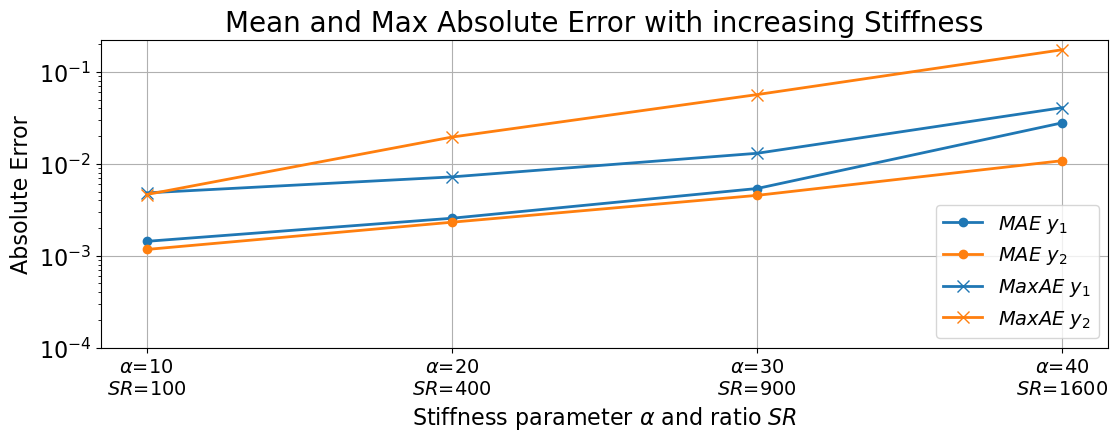

In [5]:
import json

# history = {}
# history["alpha_list"] = alpha_list
# history["mae_y1"] = mae_y1
# history["mae_y2"] = mae_y2
# history["maxae_y1"] = maxae_y1
# history["maxae_y2"] = maxae_y2

# with open(r"D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\result_history\Duffing_Error_Trained.json",  "w") as fp:
#     json.dump(history, fp)

with open(r"D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\result_history\Duffing_Error_Trained.json") as f:
    history = json.load(f)
    alpha_list = history["alpha_list"] 
    mae_y1 = history["mae_y1"] 
    mae_y2 = history["mae_y2"] 
    maxae_y1 = history["maxae_y1"]
    maxae_y2 = history["maxae_y2"]


fig, ax = plt.subplots(1, figsize=(13, 4))

ax.plot(alpha_list, mae_y1, "-o", label="$MAE$ ${y_1}$", linewidth=2, markersize=6)
ax.plot(alpha_list, mae_y2,"-o", label="$MAE$ ${y_2}$", linewidth=2, markersize=6)
ax.plot(alpha_list, maxae_y1, "-x", color="#1f77b4", label="$MaxAE$ ${y_1}$", linewidth=2, markersize=8)
ax.plot(alpha_list, maxae_y2, "-x", color="#ff7f0e", label="$MaxAE$ ${y_2}$", linewidth=2, markersize=8)

#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(r"Mean and Max Absolute Error with increasing Stiffness", fontsize=20)
ax.set_xlabel(r'Stiffness parameter $\alpha$ and ratio $SR$', fontsize=16)
ax.set_ylabel('Absolute Error', fontsize=16)
ax.set_xticks(alpha_list, [r"$\alpha$=" + str(i) + "\n" +rf"$SR$={i**2}" for i in alpha_list])
ax.set_yticks([0.1, 0.01, 0.001, 0.0001],
              [r"$10^{-1}$", r"$10^{-2}$", r"$10^{-3}$", r"$10^{-4}$"])
ax.grid()
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='best', fontsize=14)